# Total Pressure Inlet Condition 

In [1]:
using Ferrite
using SparseArrays
using LinearAlgebra 
using UnPack 
using OrdinaryDiffEq
using DifferentialEquations
using WriteVTK
using Plots 
using Logging 

In [2]:
?generate_grid

search: generate_grid @generated Base.Generator



```
generate_grid(celltype::Cell, nel::NTuple, [left::Vec, right::Vec)
```

Return a `Grid` for a rectangle in 1, 2 or 3 dimensions. `celltype` defined the type of cells, e.g. `Triangle` or `Hexahedron`. `nel` is a tuple of the number of elements in each direction. `left` and `right` are optional endpoints of the domain. Defaults to -1 and 1 in all directions.


## Section 1: Introduction 

The <b>total pressure inlet condition</b> imposes that on the inlet patch $p_{total} = p_{static} + p_{dynamic}$. We recall that only total quantities are conserved. The condition implies that 
$p_{total} = p_{static} + 0.5 \, \rho \, \vec{v} \cdot \vec{v}$, where $p_{static}$ is the pressure solved for in the Navier-Stokes model. Physically speaking, we have that 

<b>Initial Pressure Difference</b>: If the inlet pressure (total pressure) is higher than the initial pressure inside the vessel, fluid flows into the vessel, increasing the internal pressure. This flow is driven by the pressure gradient between the inlet and the pressure inside the reservoir.
What happens next:

<b>Pressure Equilibration</b>: As fluid enters the closed vessel, the inner static pressure rises. For incompressible flow (or compressible flow within a rigid reservoir), the pressure increase is directly related to the added mass. For compressible fluids, density changes also contribute to pressure buildup and must be taken into account.

<b>Dynamic to Static Pressure Transition</b>: The inlet's total pressure includes static and dynamic components. As the vessel's internal static pressure approaches the inlet's total pressure, the dynamic pressure (velocity-dependent term) diminishes, slowing the flow.

<b>Steady-State Condition</b>: When the vessel's static pressure equals the inlet's total pressure, the pressure gradient driving the flow vanishes. At this point, the inflow velocity reduces to zero, and the system reaches a steady state with no net flow. See also, [this video](https://www.youtube.com/watch?v=Er2j5Kq17as)

The total pressure inlet condition is standard in various packages. These include 
[Fluent Users Guide](https://www.afs.enea.it/project/neptunius/docs/fluent/html/ug/node239.htm) and [OpenFoam Example](https://doc.openfoam.com/2306/tools/processing/boundary-conditions/rtm/derived/inletOutlet/totalPressure/). In this notebook we explore the implementation of this non-linear boundary condition is an existing FEM solver.   

## Section 2: Linear Scalar Diffusion  

### 2.1: Model Problem 

**The Poisson Equation**

$$-\nabla^2 u(\mathbf{x}) = f(\mathbf{x}) \quad \text{on } \Omega$$

Where:
* $\mathbf{x}$ represents the spatial coordinates $(x, y)$ in our 2D case.
* $\nabla^2$ is the Laplacian operator, defined as $\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}$. It describes the diffusion or distribution of $u$.
* $f(\mathbf{x})=1$ is a constant source term applied throughout the domain.


**The Domain and Boundary Conditions (BCs)**

Our computational domain $\Omega$ is a 2D rectangle. To solve the Poisson equation, we must specify boundary conditions (BCs) on the boundary $\partial \Omega$ of this domain. The provided code implements the following conditions:

1.  **Dirichlet BC**

    While the code specifically sets a condition on the "left" side, for a scalar diffusion problem like the Poisson equation, the other boundaries often implicitly have Neumann (zero-flux) boundary conditions if no other BCs are explicitly defined. This means no quantity is entering or leaving through these boundaries by diffusion.

    Using a Dirichlet boundary condition (such as $u=10.0$ on `left_patch`) is sufficient to make the Poisson problem non-singular and guarantee a unique solution for $u$.

    $$u(\mathbf{\text{left patch}}) = 10.0$$

2.  **Mean Average Constraint**

Dirichlet homogeneous conditions on three sides (top, bottom, right) fix the value of $u$ to zero, preventing trivial solutions.

Instead of fixing a point value, we impose a *mean* value on the remaining left boundary. This provides the necessary "anchor" for the solution, determining the overall level of $u$ on that specific boundary without strictly fixing every point. This is often more physically realistic in certain scenarios than a uniform Dirichlet condition.
    $$\frac{1}{L_{\text{left}}} \int_{\text{left boundary}} u \, ds = 10.0$$

This combination avoids the singularity issues that arise from imposing Neumann conditions on all boundaries (solution unique up to a constant) or Dirichlet homogeneous on all boundaries (trivial solution $u=0$).

3. **Penalty Method**

For the linear constraints using the [penalty method](https://en.wikipedia.org/wiki/Penalty_method), it suffices to add a boundary term to the weak form. More specifically, one adds to the weak form the weighting factor. The weighting factor p is initially zero and increases (to give more weight to the constraint to be imposed) as convergence is obtained. 

For the implementation of integrals over the boundary, the incompressible elasticity tutorial provides a good example. Look for the comment “We integrate the Neumann boundary using the FacetValues.” This part of the weak form needs to be updated with time. This is similar to the update of the non-linear part of the Jacobian in the incompressible Navier-Stokes tutorial. 

4. **Lagrange Multipliers**

For the linear constraints using this time Lagrange multipliers (as opposed to AffineConstraints that Ferrite already provides), I would need to look into the details. (For now, see [Lagrangian multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier). 

### 2.2: Numerical Solution

##### 2.2.1 Dirichlet and Mean Average Constraint

In [15]:
# grid = generate_grid(Quadrilateral, (100, 100));
nelem = 100 
nels  = (nelem, nelem) # number of elements in each spatial direction
grid = generate_grid(Quadrilateral, nels);

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint 

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

ch = ConstraintHandler(dh);

In [16]:
function assemble_K!(K::SparseMatrixCSC, f::Vector, cellvalues::CellValues, dh::DofHandler)

    n_basefuncs = getnbasefunctions(cellvalues)
    Ke = zeros(n_basefuncs, n_basefuncs)
    fe = zeros(n_basefuncs)

    assembler = start_assemble(K, f)

    for cell in CellIterator(dh)

        fill!(Ke, 0)
        fill!(fe, 0)

        Ferrite.reinit!(cellvalues, cell)

        for q_point in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q_point)

            for i in 1:n_basefuncs
                v = shape_value(cellvalues, q_point, i)
                ∇v = shape_gradient(cellvalues, q_point, i)
                fe[i] += v * dΩ
                #fe[i] += 0 ---------------------------------------------------------
                for j in 1:n_basefuncs
                    ∇u = shape_gradient(cellvalues, q_point, j)
                    Ke[i, j] += (∇v ⋅ ∇u) * dΩ
                end
            end
        end

        assemble!(assembler, celldofs(cell), Ke, fe)
    end
    return K, f
end

assemble_K! (generic function with 1 method)

In [17]:
function setup_mean_constraint(dh, fvu)
    assembler = Ferrite.COOAssembler()
    # All external boundaries
    set = union(getfacetset(dh.grid, "left"))
    # Allocate buffers
    range_u = dof_range(dh, :u)
    element_dofs = zeros(Int, ndofs_per_cell(dh))
    element_dofs_u = view(element_dofs, range_u)
    element_coords = zeros(Vec{2}, 4) # assuming 2D mesh with quadrilaterals only
    Ce = zeros(1, length(range_u)) # Local constraint matrix (only 1 row)
    # Loop over all the boundaries
    for (ci, fi) in set
        Ce .= 0
        getcoordinates!(element_coords, dh.grid, ci)
        Ferrite.reinit!(fvu, element_coords, fi)
        celldofs!(element_dofs, dh, ci)
        for qp in 1:getnquadpoints(fvu)
            dΓ = getdetJdV(cvu, qp)
            for i in 1:getnbasefunctions(fvu)
                Ce[1, i] += shape_value(fvu, qp, i) * dΓ
            end
        end
        # Assemble to row 1
        assemble!(assembler, [1], element_dofs_u, Ce)
    end
    C, _ = finish_assemble(assembler)
    # Create an AffineConstraint from the C-matrix
    _, J, V = findnz(C)
    _, constrained_dof_idx = findmax(abs2, V)
    constrained_dof = J[constrained_dof_idx]
    V ./= V[constrained_dof_idx]
    mean_value_constraint = AffineConstraint(
        constrained_dof,
        Pair{Int, Float64}[J[i] => -V[i] for i in 1:length(J) if J[i] != constrained_dof],
        10.0,
    )
    return mean_value_constraint
end

setup_mean_constraint (generic function with 1 method)

In [19]:
function mypostprocess(u, dh, cvu, nels)

    numcells = nels[1]*nels[2]
    area = zeros(numcells)
    myu  = zeros(numcells)

    for (cell_num, cell) in enumerate(CellIterator(dh))

        Ferrite.reinit!(cvu, cell)
        
        dof_range_u = dof_range(dh,:u)
        uloc = u[celldofs(dh,cell_num)[dof_range_u]]
        Ferrite.reinit!(cvu, cell)

        cellarea = 0. 
        cellu = 0 
    
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point)
            celluq = function_value(cvu, q_point, uloc)
            cellarea += dΩ 
            cellu += celluq*dΩ
        end

        area[cell_num] = cellarea
        myu[cell_num]  = cellu
    
    end  

    myu2d = reshape(myu, nels[1], nels[2])
    
    return area, myu2d 
end 

mypostprocess (generic function with 1 method)

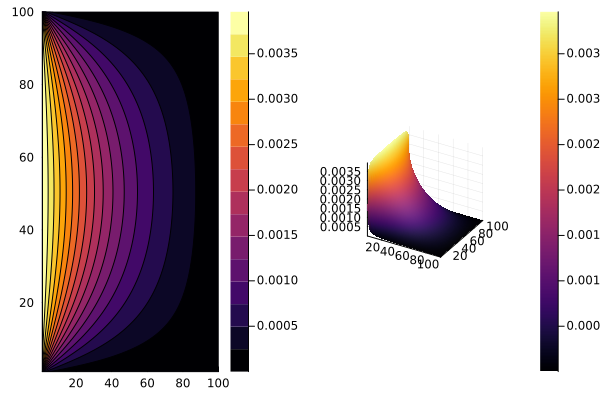

In [20]:
# Boundary conditions part: Dirichlet BC for the velocity at the top lid 
left_patch = getfacetset(dh.grid, "left")
if (true) # --------------------------------------------------------------------------------
    dbc1 = Dirichlet(:u, left_patch, (x,t) ->  10. )
else 
    dbc1 = setup_mean_constraint(dh, fvu)
end 
add!(ch, dbc1)

# Add Homogeneous Dirichlet Boundary conditions ---------------------------------------------
top_patch = getfacetset(dh.grid, "top")
bottom_patch = getfacetset(dh.grid, "bottom")
right_patch = getfacetset(dh.grid, "right")

# Create Dirichlet BCs for u=0 on these patches
dbc_top = Dirichlet(:u, top_patch, (x,t) -> 0.0)
dbc_bottom = Dirichlet(:u, bottom_patch, (x,t) -> 0.0)
dbc_right = Dirichlet(:u, right_patch, (x,t) -> 0.0)

# Add these new Dirichlet BCs to the ConstraintHandler
add!(ch, dbc_top)
add!(ch, dbc_bottom)
add!(ch, dbc_right)

close!(ch);

K = allocate_matrix(dh,ch);
M = allocate_matrix(dh,ch);
f = zeros(ndofs(dh));

K, f = assemble_K!(K, f, cvu, dh);
apply!(K, f, ch)
u = K \ f;

VTKGridFile("diffusion", dh) do vtk
    write_solution(vtk, dh, u)
    Ferrite.write_constraints(vtk, ch)
end

area, myu2d = mypostprocess(u, dh, cvu, nels)
p1 = contour(myu2d', fill=true)
p2 = surface(myu2d', fill=true)
plot(p1,p2, layout=(1,2))

##### 2.2.2 Penalty Method

In [5]:
# grid = generate_grid(Quadrilateral, (100, 100));
nelem = 100 
nels  = (nelem, nelem) # number of elements in each spatial direction
grid = generate_grid(Quadrilateral, nels);

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint 

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

ch = ConstraintHandler(dh);

function assemble_K_and_f_with_penalty!(K::SparseMatrixCSC, f::Vector, cellvalues::CellValues, facetvalues::FacetValues, dh::DofHandler, left_patch_cells_faces, p_penalty::Float64)
    n_basefuncs = getnbasefunctions(cellvalues)
    Ke = zeros(n_basefuncs, n_basefuncs) # Element stiffness matrix
    fe = zeros(n_basefuncs)             # Element force vector

    assembler = start_assemble(K, f) # Initializes/resets K and f for assembly

    for cell in CellIterator(dh)

        fill!(Ke, 0.0) # Ensure elemental matrices are zeroed for each cell
        fill!(fe, 0.0)

        Ferrite.reinit!(cellvalues, cell) # Reinitialize cellvalues for the current cell

        # --- Domain integration (diffusion and source term) ---
        for q_point in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q_point) # Differential volume element

            f_val = 1.0 # Source term f (e.g., constant heat source)

            for i in 1:n_basefuncs
                v = shape_value(cellvalues, q_point, i)      # Shape function phi_i
                ∇v = shape_gradient(cellvalues, q_point, i) # Gradient of shape function phi_i
                
                # Contribution to elemental force vector (fe) from source term (f*v)
                fe[i] += f_val * v * dΩ
                
                for j in 1:n_basefuncs
                    ∇u = shape_gradient(cellvalues, q_point, j) # Gradient of shape function phi_j
                    # Contribution to elemental stiffness matrix (Ke) from diffusion term (∇v ⋅ ∇u)
                    Ke[i, j] += (∇v ⋅ ∇u) * dΩ
                end
            end
        end

        # --- Boundary integration (penalty term for left_patch) ---
        # This loop checks each facet of the current cell
        for face in 1:nfacets(cell)
            # If the current facet belongs to the 'left_patch' (where we apply penalty)
            if (cellid(cell), face) ∈ left_patch_cells_faces 
                
                Ferrite.reinit!(facetvalues, cell, face) # Reinitialize facetvalues for this specific facet
                
                for q_point_facet in 1:getnquadpoints(facetvalues)
                    dΓ = getdetJdV(facetvalues, q_point_facet) # Differential surface element

                    u_target = 10.0 # The desired value for u on the left_patch (Dirichlet value)

                    for i in 1:n_basefuncs
                        v_i = shape_value(facetvalues, q_point_facet, i) # Shape function phi_i
                        
                        # Contribution to elemental force vector (fe) from penalty: p_penalty * u_target * v_i
                        # This term pulls the solution towards u_target
                        fe[i] += p_penalty * u_target * v_i * dΓ

                        for j in 1:n_basefuncs
                            u_j = shape_value(facetvalues, q_point_facet, j) # Shape function phi_j
                            # Contribution to elemental stiffness matrix (Ke) from penalty: p_penalty * v_i * u_j
                            # This term represents the stiffness of the "penalty spring"
                            Ke[i, j] += p_penalty * v_i * u_j * dΓ
                        end
                    end
                end
            end
        end
        
        # Assemble the elemental matrices (Ke) and vectors (fe) into the global K and f
        assemble!(assembler, celldofs(cell), Ke, fe)
    end
    return K, f
end

# Boundary conditions part: Dirichlet BC 
left_patch = getfacetset(dh.grid, "left")
top_patch = getfacetset(dh.grid, "top")
bottom_patch = getfacetset(dh.grid, "bottom")
right_patch = getfacetset(dh.grid, "right")

# Create Dirichlet BCs for u=0 on these patches
#dbc_left = Dirichlet(:u, left_patch, (x,t) ->  10. )
dbc_top = Dirichlet(:u, top_patch, (x,t) -> 0.0)
dbc_bottom = Dirichlet(:u, bottom_patch, (x,t) -> 0.0)
dbc_right = Dirichlet(:u, right_patch, (x,t) -> 0.0)

# Add these new Dirichlet BCs to the ConstraintHandler
#add!(ch, dbc_left)
add!(ch, dbc_top)
add!(ch, dbc_bottom)
add!(ch, dbc_right)

close!(ch);

# Penalty Loop and Solution Function ---
function solve_poisson_penalty(dh::DofHandler, ch::ConstraintHandler, cvu::CellValues, fvu::FacetValues, left_patch_cells_faces)
    ndofs_total = ndofs(dh)
    
    # Penalty parameters
    p_penalty_initial = 1.0e0    # Starting penalty factor
    p_penalty_max = 1.0e8        # Maximum penalty factor
    p_increase_factor = 10.0     # Factor to increase penalty by in each iteration
    num_penalty_iterations = 7   # Number of penalty iterations

    # Initialize solution vector
    u_solution = zeros(ndofs_total) 

    current_p_penalty = p_penalty_initial
    
    # Outer loop for penalty parameter
    for penalty_iter in 1:num_penalty_iterations 
        @info "--- Penalty Iteration $(penalty_iter), p_penalty = $(current_p_penalty) ---"
        
        # Allocate global stiffness matrix K and force vector f for the current penalty iteration
        K = allocate_matrix(dh, ch); 
        f = zeros(ndofs_total);

        assemble_K_and_f_with_penalty!(K, f, cvu, fvu, dh, left_patch_cells_faces, current_p_penalty)

        # Apply explicit Dirichlet boundary conditions (top, bottom, right)
        Ferrite.apply!(K, f, ch) 
        
        # Solve the linear system for the current penalty value
        u_solution = K \ f;
        
        @info "  System solved for p_penalty = $(current_p_penalty)"

        # Prepare for the next penalty iteration by increasing the penalty parameter
        current_p_penalty *= p_increase_factor
        # Cap the penalty parameter at p_penalty_max to prevent numerical issues with excessively large values
        if current_p_penalty > p_penalty_max
            current_p_penalty = p_penalty_max
        end
    end
    
    return u_solution # Return the final solution after all penalty iterations
end

penalty_u = solve_poisson_penalty(dh, ch, cvu, fvu, left_patch);

VTKGridFile("diffusion_penalty_linear_u10", dh) do vtk
    write_solution(vtk, dh, final_u)
    Ferrite.write_constraints(vtk, ch)
end

[ Info: --- Penalty Iteration 1, p_penalty = 1.0 ---
[ Info:   System solved for p_penalty = 1.0
[ Info: --- Penalty Iteration 2, p_penalty = 10.0 ---
[ Info:   System solved for p_penalty = 10.0
[ Info: --- Penalty Iteration 3, p_penalty = 100.0 ---
[ Info:   System solved for p_penalty = 100.0
[ Info: --- Penalty Iteration 4, p_penalty = 1000.0 ---
[ Info:   System solved for p_penalty = 1000.0
[ Info: --- Penalty Iteration 5, p_penalty = 10000.0 ---
[ Info:   System solved for p_penalty = 10000.0
[ Info: --- Penalty Iteration 6, p_penalty = 100000.0 ---
[ Info:   System solved for p_penalty = 100000.0
[ Info: --- Penalty Iteration 7, p_penalty = 1.0e6 ---
[ Info:   System solved for p_penalty = 1.0e6


VTKGridFile for the closed file "diffusion_penalty_linear_u10.vtu".

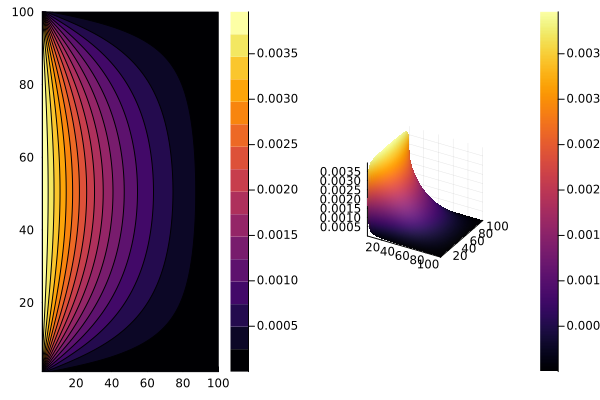

In [6]:
function mypostprocess(u, dh, cvu, nels)

    numcells = nels[1]*nels[2]
    area = zeros(numcells)
    myu  = zeros(numcells)

    for (cell_num, cell) in enumerate(CellIterator(dh))

        Ferrite.reinit!(cvu, cell)
        
        dof_range_u = dof_range(dh,:u)
        uloc = u[celldofs(dh,cell_num)[dof_range_u]]
        Ferrite.reinit!(cvu, cell)

        cellarea = 0.0
        cellu = 0.0
        
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point)
            celluq = function_value(cvu, q_point, uloc)
            cellarea += dΩ
            cellu += celluq * dΩ
        end

        area[cell_num] = cellarea
        myu[cell_num]  = cellu
    
    end
    
    myu2d = reshape(myu, nels[1], nels[2])
    
    return area, myu2d
end

area, myu2d = mypostprocess(penalty_u, dh, cvu, nels)
p1 = contour(myu2d', fill=true)
p2 = surface(myu2d', fill=true)
plot(p1,p2, layout=(1,2))

## Section 3 : Non linear Scalar Diffusion  

### 3.1 Model Problem

**The Poisson Equation**

We are still solving the Poisson equation on our domain $\Omega$:

$$-\nabla^2 u(\mathbf{x}) = f(\mathbf{x}) \quad \text{on } \Omega$$

The constant source term $f(\mathbf{x})=1$ is applied throughout the domain.

We maintain homogeneous Dirichlet conditions ($u=0$) on the top, bottom, and right boundaries.

However, we are now implementing a non-linear Dirichlet boundary condition on the left patch :

$$u(\mathbf{\text{left patch}})^2 = 100$$

This non-linear condition makes the overall problem non-linear, requiring iterative solution methods.


### 3.2 Solution Approaches    

#### 3.2.1 : Transient Penalty Method 

For robustly solving our non-linear steady-state Poisson problem, a smart implementation is crucial.

We will achieve this by solving a transient form of the Poisson equation:

$$\frac{\partial u}{\partial t} - \nabla^2 u = f \quad \text{on } \Omega$$

Here, the non-linear Dirichlet condition $u(\mathbf{\text{left patch}})^2 = 100$ will be enforced using a penalty method. The key idea, as suggested, is to make the penalty parameter $p$ time-dependent, e.g., $p(t) = t$.

This leads to a weak formulation of the problem involving a time derivative and a time-dependent penalty term on the boundary:

$$\int_\Omega \frac{\partial u}{\partial t} v \, d\Omega + \int_\Omega \nabla u \cdot \nabla v \, d\Omega - \int_\Omega f v \, d\Omega + \int_{\text{left patch}} p(t) \cdot (u^2 - 100) \cdot u \cdot v \, d\Gamma = 0$$

This approach allows us to:

* Automate Parameter Ramping:The increase of the penalty parameter $p(t)=t$ is intrinsically handled by the time integration.
* Delegate Solution Process: We can leverage specialized ODE/DAE solvers (e.g., `DifferentialEquations.jl`) to manage the entire process, including the non-linear iterations (Newton's method) at each "time" step and the stable evolution of the solution as $p(t)$ increases.

This method effectively transforms the complex "inner-outer" iteration scheme (in which the outer iteration governs the value of the penalty parameter and in which the inner iteration solves a system of non-linear equations for a given value of the penalty parameter) into a single, solvable transient problem, greatly simplifying the implementation.


### 3.3 Numerical Solutions

#### 3.3.1 Transient Penalty Method for Non Linear BC

In [3]:
# grid = generate_grid(Quadrilateral, (100, 100));
nelem = 20 
nels  = (nelem, nelem) # number of elements in each spatial direction
grid = generate_grid(Quadrilateral, nels);

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint 

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

ch = ConstraintHandler(dh);

In [4]:
# This matrix corresponds to the ∂u/∂t term in the weak form: ∫ (∂u/∂t) v dΩ
function assemble_mass_matrix!(M::SparseMatrixCSC, cellvalues::CellValues, dh::DofHandler)
    n_basefuncs = getnbasefunctions(cellvalues)
    Me = zeros(n_basefuncs, n_basefuncs) 
    assembler = start_assemble(M)
    
    for cell in CellIterator(dh)
        fill!(Me, 0.0)
        Ferrite.reinit!(cellvalues, cell)

        for q_point in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q_point)
            for i in 1:n_basefuncs
                v_i = shape_value(cellvalues, q_point, i)
                for j in 1:n_basefuncs
                    u_j = shape_value(cellvalues, q_point, j)
                    Me[i, j] += v_i * u_j * dΩ # ∫ (phi_i * phi_j) dΩ
                end
            end
        end
        assemble!(assembler, celldofs(cell), Me)
    end
    return M
end

assemble_mass_matrix! (generic function with 1 method)

In [5]:
# Assemble Jacobian (J) and Residual (R) for the Spatial Part ---
# This function now calculates the non-linear spatial residual (R) and its Jacobian (J).
function assemble_jacobian_residual!(J::SparseMatrixCSC, R::Vector, cellvalues::CellValues, facetvalues::FacetValues, dh::DofHandler, u_current::Vector, left_patch_cells_faces, t::Float64)
                                                                                                                                                           
    n_basefuncs = getnbasefunctions(cellvalues)
    Je = zeros(n_basefuncs, n_basefuncs) 
    re = zeros(n_basefuncs)             

    assembler = start_assemble(J, R) 

    for cell in CellIterator(dh)

        fill!(Je, 0.0)
        fill!(re, 0.0)

        Ferrite.reinit!(cellvalues, cell)
        
        # Get the current solution values for the DOFs within this cell
        cell_u_current = u_current[celldofs(cell)]

        # --- Domain integration (diffusion and source term) ---
        for q_point in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q_point) 

            f_val = 1.0 # Source term f

            # Evaluate gradient of current solution at quadrature point
            ∇u_current_q = function_gradient(cellvalues, q_point, cell_u_current)

            for i in 1:n_basefuncs
                v = shape_value(cellvalues, q_point, i)      
                ∇v = shape_gradient(cellvalues, q_point, i) 
                
                # Contribution to elemental residual (re): ∇u_current ⋅ ∇v - f_val * v
                re[i] += (∇u_current_q ⋅ ∇v - f_val * v) * dΩ
                
                for j in 1:n_basefuncs
                    ∇u_j = shape_gradient(cellvalues, q_point, j) # Gradient of basis function phi_j
                    # Contribution to elemental Jacobian (Je) from diffusion term: (∇v ⋅ ∇u_j)
                    Je[i, j] += (∇v ⋅ ∇u_j) * dΩ
                end
            end
        end

        # --- Boundary integration (NON-LINEAR penalty term for left_patch) ---
        for face in 1:nfacets(cell)
            if FacetIndex(cellid(cell), face) ∈ left_patch
                
                Ferrite.reinit!(facetvalues, cell, face) 
                
                for q_point_facet in 1:getnquadpoints(facetvalues)
                    dΓ = getdetJdV(facetvalues, q_point_facet) 

                    # Current penalty parameter, which depends on time 't'
                    p_penalty = t
                    # p_penalty = max(1.0e-3, t) or p_penalty = t * 1.0e0 
                    
                    # Evaluate current solution 'u' at the facet quadrature point
                    u_q_current = function_value(facetvalues, q_point_facet, cell_u_current)

                    # Target value for the non-linear constraint (u^2 = 100 => u_target_squared = 100)
                    u_target_squared = 100.0 

                    for i in 1:n_basefuncs
                        v_i = shape_value(facetvalues, q_point_facet, i) 
                        
                        # Contribution to elemental residual (re) from penalty: p * (u^2 - u_target_squared) * v_i
                        re[i] += p_penalty * (u_q_current^2 - u_target_squared) * v_i * dΓ

                        for j in 1:n_basefuncs
                            u_j = shape_value(facetvalues, q_point_facet, j) # Basis function phi_j
                            # This is the derivative of the penalty residual w.r.t. u_j
                            Je[i, j] += p_penalty * 2.0 * u_q_current * v_i * u_j * dΓ
                        end
                    end
                end
            end
        end
        
        assemble!(assembler, celldofs(cell), Je, re)
    end
    return J, R
end


assemble_jacobian_residual! (generic function with 1 method)

In [6]:
# Boundary conditions part: Dirichlet BC 
left_patch = getfacetset(dh.grid, "left")
top_patch = getfacetset(dh.grid, "top")
bottom_patch = getfacetset(dh.grid, "bottom")
right_patch = getfacetset(dh.grid, "right")

# Create Dirichlet BCs for u=0 on these patches
#dbc_left = Dirichlet(:u, left_patch, (x,t) ->  10. )
dbc_top = Dirichlet(:u, top_patch, (x,t) -> 0.0)
dbc_bottom = Dirichlet(:u, bottom_patch, (x,t) -> 0.0)
dbc_right = Dirichlet(:u, right_patch, (x,t) -> 0.0)

# Add these new Dirichlet BCs to the ConstraintHandler
#add!(ch, dbc_left)
add!(ch, dbc_top)
add!(ch, dbc_bottom)
add!(ch, dbc_right)

close!(ch);

In [7]:
# ODE Function for DifferentialEquations.jl ---
# This function defines the right-hand side of M * du/dt = -R(u,t)
function ode_function!(dR, u, p_ode, t)
    # Extract parameters from p_ode tuple
    dh, ch, cvu, fvu, left_patch = p_ode

    # Allocate Jacobian and Residual vectors/matrices
    J = allocate_matrix(dh, ch) 
    R_spatial = zeros(ndofs(dh))
    
    # Assemble the Jacobian and Spatial Residual for the current u and t
    assemble_jacobian_residual!(J, R_spatial, cvu, fvu, dh, u, left_patch, t)

    # Apply explicit Dirichlet boundary conditions to J and R_spatial
    Ferrite.apply!(J, R_spatial, ch) 
    
    # The ODE problem is M * du/dt = -R_spatial
    dR .= -R_spatial # Fill the output vector dR
    return nothing
end

# Main function to solve the transient problem ---
function solve_transient_poisson_penalty(dh::DofHandler, ch::ConstraintHandler, cvu::CellValues, fvu::FacetValues, left_patch)
    
    ndofs_total = ndofs(dh)
    
    # Initial condition for u at t=0 (e.g., all zeros)
    u0 = zeros(ndofs_total) 

    # Time span for the transient simulation
    tspan = (0.0, 50.0) 

    # Parameters to pass to the ODE function (dh, ch, etc.)
    params = (dh, ch, cvu, fvu, left_patch)

    # Assemble the global mass matrix once (it's constant for this problem)
    M_global = assemble_mass_matrix!(allocate_matrix(dh, ch), cvu, dh)
    
    # This tells DifferentialEquations.jl that it's a MassMatrix problem (M * du/dt = f(u,t)).
    f_ode_prob = ODEFunction(ode_function!, mass_matrix=M_global)
    
    # Define the ODE problem using the ODEFunction
    ode_prob = ODEProblem(f_ode_prob, u0, tspan, params) 

    # Solve the ODE problem using an implicit solver 
    sol = solve(ode_prob, Rodas5(autodiff=AutoFiniteDiff()), reltol=1e-6, abstol=1e-8, progress=true)

    # The final solution is the solution at the last time step
    final_u = sol.u[end] 
    
    return final_u 
        
end

final_u = solve_transient_poisson_penalty(dh, ch, cvu, fvu, left_patch);

# --- Post-processing and VTK export ---
VTKGridFile("diffusion_penalty_transient_nonlinear_u100", dh) do vtk
    write_solution(vtk, dh, final_u)
    Ferrite.write_constraints(vtk, ch) 
end 

println("Solution saved to diffusion_penalty_transient_nonlinear_u100.vtu")

Solution saved to diffusion_penalty_transient_nonlinear_u100.vtu
